### set session

In [1]:
name = 'ANA1'
session = '20231211_d21'
num_trials = 143

### imports

In [2]:
from scipy import io
import numpy as np
import matplotlib.pyplot as plt
import statistics
import pandas as pd
import pickle
import glob # find files in a directory
import re # regex for string parsing
from sympy import symbols, diff, Eq, solve

from common.set_matplotlib_settings import set_matplotlib_settings
from common.load_tonedisc_matfile import load_tonedisc_matfile
from common.select_trials import select_hit_trials
from analysis.common.analyze_time_series import make_percent_scaled
from common.extract_movement_intervals import extract_movement_intervals
from jerk.get_jerks import get_jerks
from jerk.get_point_acceleration import get_point_acceleration
from jerk.calculate_minimum_jerk import solve_x_coefficients, minimum_jerk_function, smoothest_x_function

In [3]:
tone_discriminiation_matfile = '../Data_Copy/ToneDiscrimination/'+name+'/ToneDisc_'+name+'_'+session+'.mat'
params, response, respMTX, MTXTrialType = load_tonedisc_matfile(tone_discriminiation_matfile)

Velocity_folder = "../Data_Copy/AnalysisData/"+name+"/Velocity_"+name+"_"+session+"/"
PreprocessLeverData_folder = "../Data_Copy/AnalysisData/"+name+"/PreprocessLeverData_"+name+"_"+session+"/"
HitMovements_folder = "../Data_Copy/AnalysisData/"+name+"/HitMovements_"+name+"_"+session+"/"
output_folder = "../Data_Copy/AnalysisData/"+name+"/Jerk_"+name+"_"+session+"/"

respMTX shape: (143, 7)
MTXTrialType shape: (1000, 5)
number of trials: 143


for mac:

In [4]:
!mkdir {output_folder}

mkdir: ../Data_Copy/AnalysisData/ANA1/Jerk_ANA1_20231211_d21/: File exists


for windows:

In [5]:
!mkdir "{output_folder}"

mkdir: ../Data_Copy/AnalysisData/ANA1/Jerk_ANA1_20231211_d21/: File exists


### An example window cutoff frequency calculation

In [6]:
samples = 201
f_sampling = 5888
M = (samples - 1) / 2
f_c=5 / (3.2*M - 4.6)
f_cutoff = f_c /2 *f_sampling
print('f_cutoff', f_cutoff, "Hz =", 1/(f_cutoff) *1000, 'ms')
print('200 Hz = 5 ms')
print('fastest movement: about', 1/50 * 1000, 'ms')

f_cutoff 46.6708941027267 Hz = 21.42663043478261 ms
200 Hz = 5 ms
fastest movement: about 20.0 ms


### calculate jerks for all trials

In [21]:
window_duration = 0.005
get_jerks(num_trials, window_duration, Velocity_folder, PreprocessLeverData_folder, output_folder)

calculated samples per window:  29
calculated samples per window:  29
calculated samples per window:  29
calculated samples per window:  29
calculated samples per window:  29
calculated samples per window:  29
calculated samples per window:  29
calculated samples per window:  29
calculated samples per window:  29
calculated samples per window:  29
calculated samples per window:  29
calculated samples per window:  29
calculated samples per window:  29
calculated samples per window:  29
calculated samples per window:  29
calculated samples per window:  29
calculated samples per window:  29
calculated samples per window:  29
calculated samples per window:  29
calculated samples per window:  29
calculated samples per window:  29
calculated samples per window:  29
calculated samples per window:  29
calculated samples per window:  29
calculated samples per window:  29
calculated samples per window:  29
calculated samples per window:  29
calculated samples per window:  29
calculated samples p

### Find the peak of the movement

Find the index of the maximum value of leverdata in movement_trial#.npy

### Calculate the minimum jerk from start of movement to peak

1) $x(0)=x_0$
2) $v(0)=v_0$
3) $a(0)=a_0$ and 
4) $x(t_f)=x_f$
5) $v(t_f)=v_f$
6) $a(t_f)=a_f$

- solve boundary conditions


In [26]:
import numpy as np
import scipy.signal as signal
import sympy as sp
import matplotlib.pyplot as plt

def get_point_acceleration_a(trial_index, sample_index, window_duration, velocity_folder, binaries_folder):
    velocity = np.load(velocity_folder+"velocity_trial"+str(trial_index)+".npy")
    sample_times = np.fromfile(binaries_folder+"sample_times_trial"+str(trial_index)+".bin", dtype=np.double)
    num_window_samples = int(window_duration / np.median(np.diff(sample_times)))
    print("calculated samples per window: ", num_window_samples)

    # Fit a fourth-order polynomial around the specified center_index
    local_time, fit_data, poly_fit, start_index, end_index = fit_polynomial_around_index(sample_times, velocity, sample_index, num_window_samples)

    # Find the acceleration as the first derivative
    point_acceleration = derivative_at_index(local_time, fit_data)

    return point_acceleration


def fit_polynomial_around_index(time, data, center_index, window_size):
    # Define the range for the local fitting
    start_index = max(0, center_index - window_size // 2)
    end_index = min(len(time), center_index + window_size // 2 + 1)

    # Extract the local data
    local_time = time[start_index:end_index]
    local_data = data[start_index:end_index]

    # Fit a polynomial to the local data
    coefficients = np.polyfit(local_time, local_data, 4)
    poly_fit = np.poly1d(coefficients)

    # Evaluate the polynomial at all time values
    fit_data = poly_fit(local_time)

    # Plot the original data points
    plt.scatter(local_time, local_data, label='Original Data')

    # Plot the polynomial fit
    plt.plot(local_time, fit_data, label='Polynomial Fit', color='red')

    # Add labels and legend
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.legend()

    # Show the plot
    plt.show()

    return local_time, fit_data, poly_fit, start_index, end_index

def derivative_at_index(local_time, fit_data):
    index = len(fit_data) // 2
    
    delta_t = local_time[index + 1] - local_time[index - 1]
    derivative = (fit_data[index + 1] - fit_data[index - 1]) / (2 * delta_t)
    return derivative
    

In [27]:
movement_informations = np.load(HitMovements_folder+"leverpress_informations.npy")
movement_information = movement_informations[0]

trial_index = int(movement_information[0])
left_index, right_index = movement_information[1:]
left_index = int(left_index)
right_index = int(right_index)
index_a = left_index

leverdata = np.fromfile(PreprocessLeverData_folder+"processed_trial"+str(trial_index)+".bin", dtype=np.double)
index_b = np.argmax(leverdata[left_index:right_index+1]) +left_index
#index_b = right_index

velocity = np.load(Velocity_folder+"velocity_trial"+str(trial_index)+".npy")

# x_0 = leverdata[index_a]
# v_0 = velocity[index_a]
# a_0 = get_point_acceleration_a(trial_index, index_a, window_duration, Velocity_folder, PreprocessLeverData_folder)
# print(x_0, v_0, a_0)

x_0 = leverdata[index_a]
v_0 = 0
a_0 = 0
print(x_0, v_0, a_0)

# x_f = leverdata[index_b]
# v_f = velocity[index_b]
# a_f = get_point_acceleration_a(trial_index, index_b, window_duration, Velocity_folder, PreprocessLeverData_folder)
# print(x_f, v_f, a_f)

x_f = leverdata[index_b]
v_f = 0
a_f = 0

sample_times = np.fromfile(PreprocessLeverData_folder+"sample_times_trial"+str(trial_index)+".bin", dtype=np.double)
tf = sample_times[index_b] - sample_times[index_a]
print(tf)

2.9332328480240983 0 0
0.3647968929346632


In [28]:
# Define the symbols
t, C1, C2, C3, C4, C5, C6 = symbols('t C1 C2 C3 C4 C5 C6')

# Define the expression for x(t)
x_t = C1 * t**5 + C2 * t**4 + C3 * t**3 + C4 * t**2 + C5 * t + C6

# Define expressions for v(t) and a(t)
v_t = diff(x_t, t)
a_t = diff(v_t, t)

# Set up the system of equations
equations = [
    Eq(x_t.subs(t, 0), x_0),
    Eq(v_t.subs(t, 0), v_0),
    Eq(a_t.subs(t, 0), a_0),
    Eq(x_t.subs(t, tf), x_f),
    Eq(v_t.subs(t, tf), v_f),
    Eq(a_t.subs(t, tf), a_f)
]

# Solve the system of equations
solution = solve(equations, (C1, C2, C3, C4, C5, C6))

# Display the solution
print("Solution for the coefficients:")
smoothest_x_coefficients = []
for coeff, value in solution.items():
    print(f"{coeff}: {value}")
    smoothest_x_coefficients.append(value)


Solution for the coefficients:
C1: 459.503139142108
C2: -419.063293631914
C3: 101.915324973260
C4: 0.0
C5: 0.0
C6: 2.93323284802410


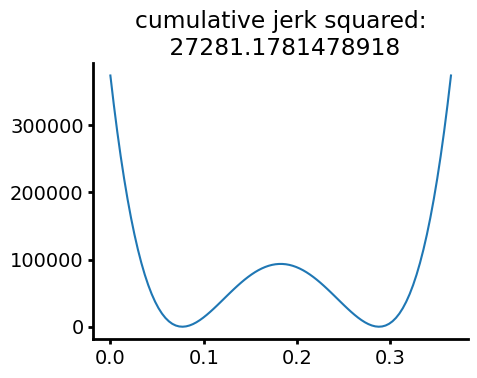

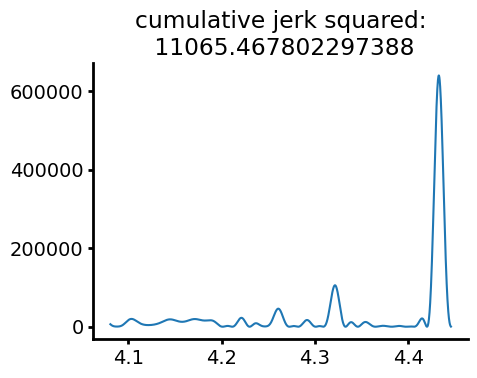

In [32]:
t_input = np.linspace(0, tf, 100)
minimum_jerk = minimum_jerk_function(smoothest_x_coefficients, t_input)
plt.plot(t_input, minimum_jerk**2)

minimum_jerk_dx = np.median(np.diff(t_input))
minimum_cumulative_jerk = np.trapz(minimum_jerk**2, dx=minimum_jerk_dx)
plt.title("cumulative jerk squared:\n " + str(minimum_cumulative_jerk))
plt.show()

jerk = np.load(output_folder+"jerk_trial"+str(trial_index)+".npy")
sample_times = np.fromfile(PreprocessLeverData_folder+"sample_times_trial"+str(trial_index)+".bin", dtype=np.double)
plt.plot(sample_times[index_a:index_b], jerk[index_a:index_b]**2)

actual_jerk_dx = np.median(np.diff(sample_times))
actual_cumulative_jerk = np.trapz(jerk[index_a:index_b]**2, dx=actual_jerk_dx)
plt.title("cumulative jerk squared:\n " + str(actual_cumulative_jerk))
plt.show()

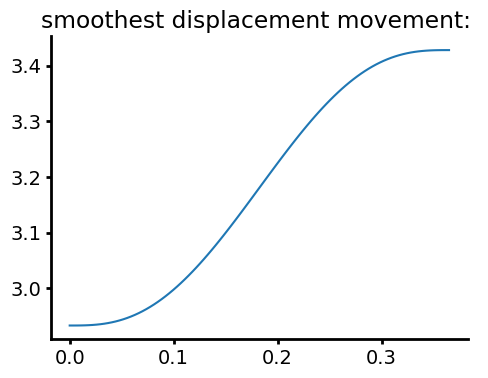

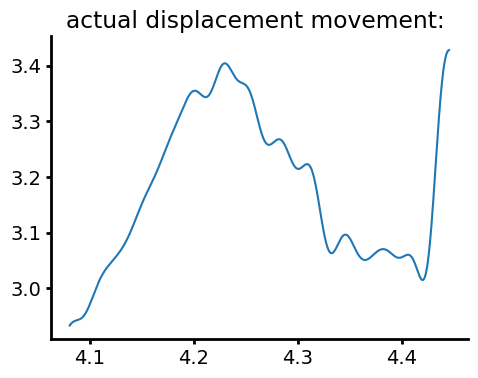

In [30]:
t_input = np.linspace(0, tf, 100)
smoothest_x = smoothest_x_function(smoothest_x_coefficients, t_input)
plt.plot(t_input, smoothest_x)
plt.title("smoothest displacement movement: ")
plt.show()

plt.plot(sample_times[index_a:index_b], leverdata[index_a:index_b])
plt.title("actual displacement movement: ")
plt.show()

### Calculate the minimum jerk from peak to end of movement